## Healthcare Recommendation System
The healthcare recommendation system is designed to provide personalized health tips to users based on their unique profiles, which include attributes such as age, gender, and medical conditions. <br>
It leverages a **content-based filtering** approach, using **Cosine Similarity** to compare users’ profiles (age, gender, and medical condition) with similar profiles in the dataset. Based on this similarity, the system recommends relevant health tips to users.<br>

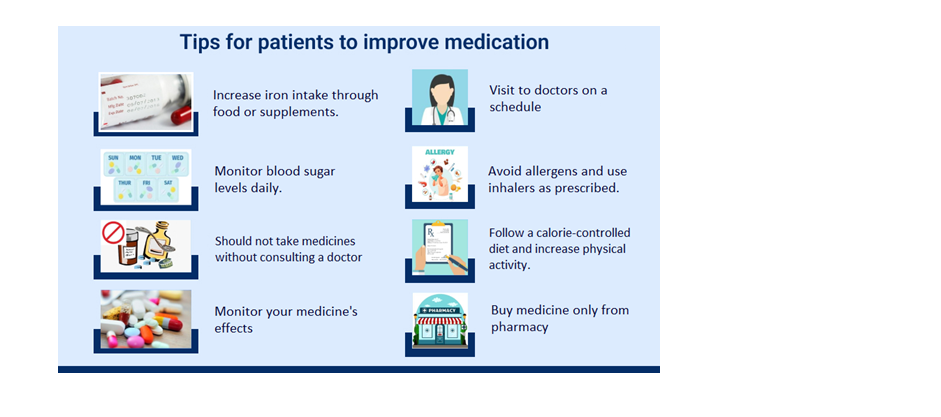 <br>



The goal of the system is to recommend health tips to new users based on the similarity of their profiles to others in the dataset.

### Step 1 : Loading the Data
Let's start by loading the health care dataset, which contains <br>

**User Profiles:**

The user profiles include the following key features:<br>
1. **Age:** Continuous numeric variable that is scaled.<br>
2. **Gender:** Categorical variable that is label-encoded.<br>
3. **Medical Condition:** Categorical variable that lists the user's health issues (*e.g., diabetes, hypertension*) and is label-encoded.<br>
These attributes are preprocessed to convert them into numerical format, enabling effective similarity calculation.<br>
4. **Health Tips:** A list of health tips associated with each user based on their medical condition.<br>



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# File path
file_path = '/content/drive/MyDrive/Assessment/Health Tips.csv'

In [ ]:
# Read Excel file
import pandas as pd
df = pd.read_csv(file_path)

In [ ]:
# Display the first 5 rows of data
df.head()

,Age,Gender,Medical Condition,Health Tip
0,21,Other,Asthma,Avoid allergens and use inhalers as prescribed.
1,27,Other,Diabetes,Monitor blood sugar levels daily.
2,52,Other,Anemia,Increase iron intake through food or supplements.
3,29,Male,Thyroid,Maintain a balanced diet with adequate iodine ...
4,78,Male,Asthma,Avoid allergens and use inhalers as prescribed.


### Step 2 : Checking for Null Values

Before proceeding with data cleaning and analysis, it's essential to check for any missing values in the dataset. Null values can impact the quality of our analysis and may require special handling. In this section, we'll examine the dataset for any null values and address them if necessary.

In [ ]:
# Check for null values in the dataset
null_count = df.isnull().sum()
print(f"Number of null values in column: \n{null_count}")


Number of null values in column: 
Age                  0
Gender               0
Medical Condition    0
Health Tip           0
dtype: int64


### Step 3 : Label Encoding
**Purpose** : Encodes categorical variables into integer labels.<br>
**Usage** : Often used for encoding target variables or categorical variables with ordinal relationships.<br>
**Advantages**:
- Converts categorical labels into integers, making them easier for machine learning algorithms to process as they typically work with numerical data.<br>

**Considerations** :
- Convert Gender and Medical Condition into numerical values using Label Encoding.<br>
- Assigns integers based on the alphabetical order or first appearance in the dataset, potentially implying an ordinal relationship between categories *(e.g., Female = 0, Male = 1, Other = 2)*, which may not always be appropriate if categories have no inherent order.




In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Label encode 'Gender' and 'Medical Condition', and scale 'Age'
label_encoder_gender = LabelEncoder()
label_encoder_condition = LabelEncoder()
age_scaler = StandardScaler()

In [ ]:
# Apply label encoding on 'Gender' and 'Medical Condition'
df['Gender_encoded'] = label_encoder_gender.fit_transform(df['Gender'])
df['Medical_Condition_encoded'] = label_encoder_condition.fit_transform(df['Medical Condition'])


In [ ]:
df.head()

,Age,Gender,Medical Condition,Health Tip,Gender_encoded,Medical_Condition_encoded
0,21,Other,Asthma,Avoid allergens and use inhalers as prescribed.,2,2
1,27,Other,Diabetes,Monitor blood sugar levels daily.,2,4
2,52,Other,Anemia,Increase iron intake through food or supplements.,2,0
3,29,Male,Thyroid,Maintain a balanced diet with adequate iodine ...,1,9
4,78,Male,Asthma,Avoid allergens and use inhalers as prescribed.,1,2


### Step 4 : Split Dataset into Train and Test

Training set: 1600 samples
Test set: 400 samples


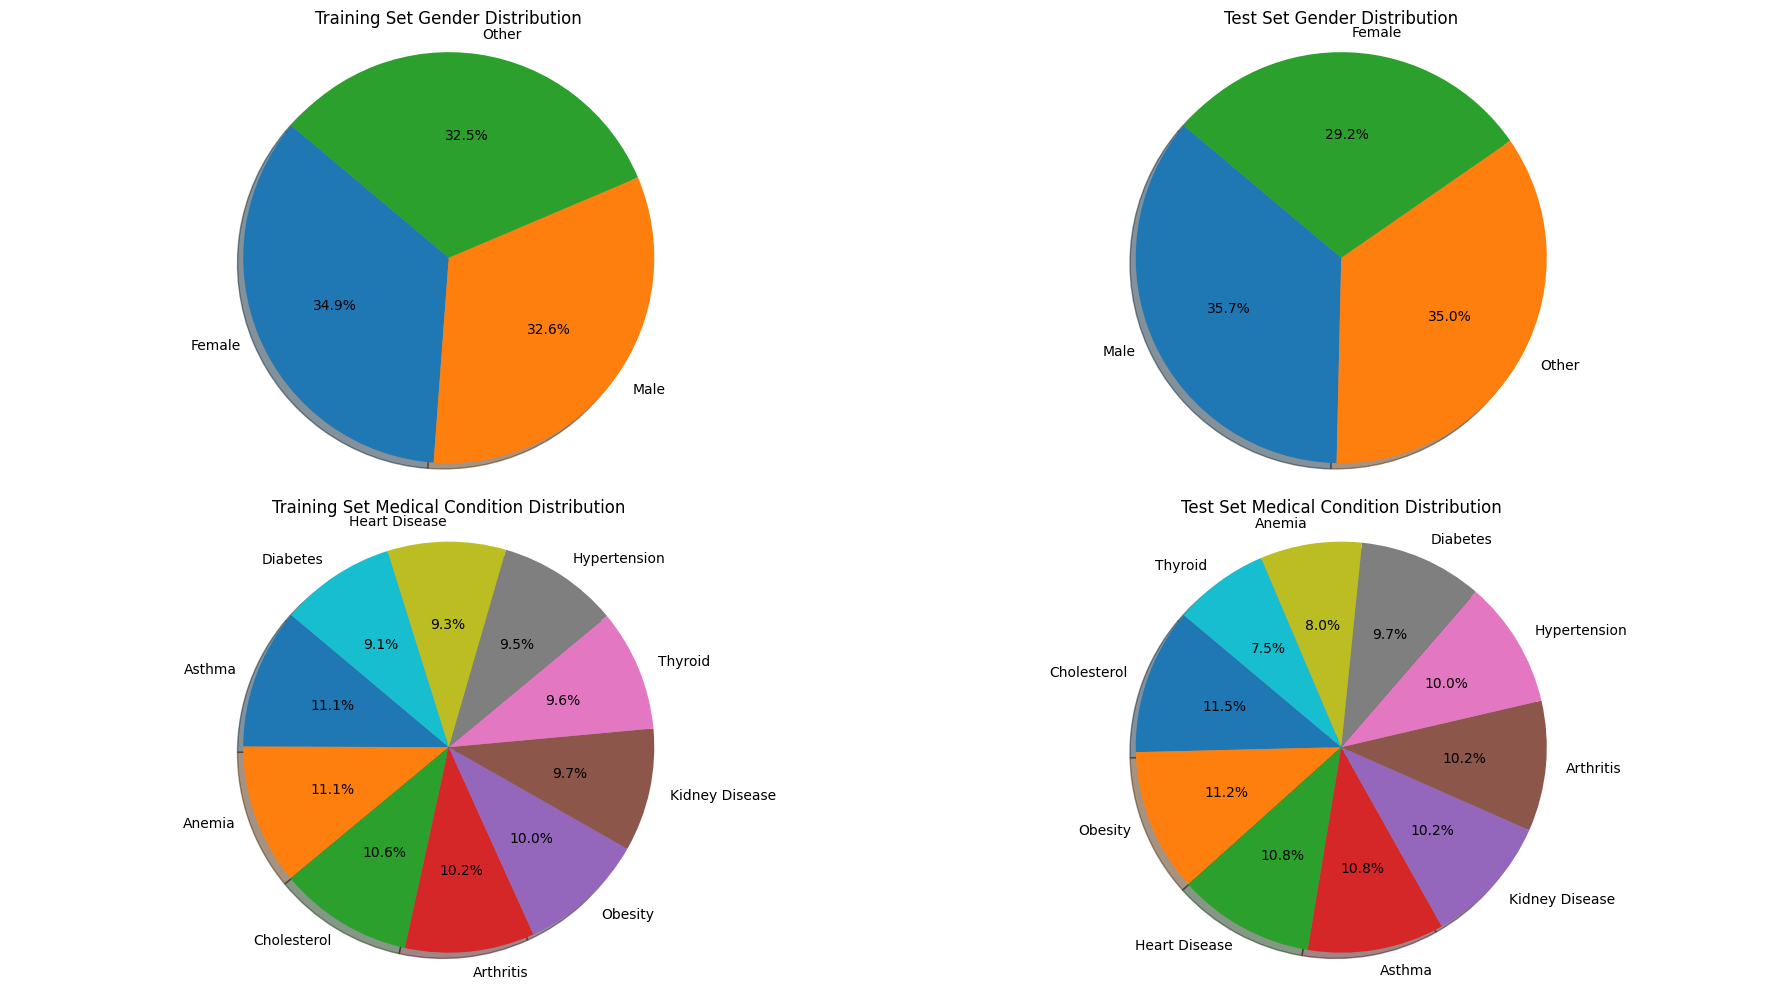

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Split the data into training (80%) and test (20%) sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


# Print the number of samples in each set
print(f'Training set: {len(train_df)} samples')
print(f'Test set: {len(test_df)} samples')


# Function to plot pie chart for categorical attributes
def plot_pie_chart(dataframe, column, title, ax):
    counts = dataframe[column].value_counts()

    # Create labels and sizes for the pie chart
    labels = counts.index
    sizes = counts.values
    colors = plt.cm.tab10.colors  # Use colormap for distinct colors
    explode = (0.1, 0)  # explode 1st slice
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',
           shadow=True, startangle=140)
    ax.set_title(title)
    ax.axis('equal')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Plot pie charts for each set and for each attribute
attributes = ['Gender', 'Medical Condition']
titles = ['Training Set', 'Test Set']

for i, attribute in enumerate(attributes):
    for j, dataset in enumerate([train_df, test_df]):
        plot_pie_chart(dataset, attribute, f'{titles[j]} {attribute} Distribution', axs[i, j])

plt.tight_layout()
plt.show()



### Step 5 : Standardizing

**Age Scaling:** Since age is a continuous variable, it is scaled using StandardScaler to normalize its values.


In [ ]:
# Scaling the 'Age' column in the training set
scaler = StandardScaler()
scaled_age_train = scaler.fit_transform(train_df[['Age']])

In [ ]:
# Label encoding for Gender and Medical Condition in the training set
label_encoder_gender = LabelEncoder()
label_encoder_med_condition = LabelEncoder()

encoded_gender_train = label_encoder_gender.fit_transform(train_df['Gender'])
encoded_med_condition_train = label_encoder_med_condition.fit_transform(train_df['Medical Condition'])


In [ ]:
# Combine scaled Age and label-encoded Gender & Medical Condition into a feature matrix for the training set
profile_vectors_train = np.hstack((scaled_age_train, encoded_gender_train.reshape(-1, 1), encoded_med_condition_train.reshape(-1, 1)))


### Step 6 : Test Data Processing
For the test data, the same scalers and encoders (from the training set) are applied to maintain consistency. The test data's feature matrix is created, and cosine similarity is calculated between the test users and training users.

In [ ]:
# Scale the 'Age' column in the test set using the same scaler
scaled_age_test = scaler.transform(test_df[['Age']])


In [ ]:
# Label encode Gender and Medical Condition in the test set using the same label encoders
encoded_gender_test = label_encoder_gender.transform(test_df['Gender'])
encoded_med_condition_test = label_encoder_med_condition.transform(test_df['Medical Condition'])


In [ ]:
# Combine scaled Age and label-encoded Gender & Medical Condition into a feature matrix for the test set
profile_vectors_test = np.hstack((scaled_age_test, encoded_gender_test.reshape(-1, 1), encoded_med_condition_test.reshape(-1, 1)))


In [ ]:
# Calculate Cosine Similarity between the test user profiles and training profiles
similarity_matrix_test = cosine_similarity(profile_vectors_test, profile_vectors_train)


###  Step 7 : Recommendations for Test Data
 The function ***recommend_health_tips_test()*** finds the top N similar users from the training dataset for each test user based on the cosine similarity and recommends health tips from those similar users.

In [ ]:
# Recommend health tips for users in the test dataset
def recommend_health_tips_test(user_index, top_n=3):
    """
    Recommend top N health tips for a given test user based on similar training user profiles.

    Parameters:
    user_index (int): Index of the user in the test dataset.
    top_n (int): Number of top similar users to consider for recommendations.

    Returns:
    List of recommended health tips from similar users without duplicates.
    """
    # Get similarity scores for the given test user
    similarity_scores = similarity_matrix_test[user_index]

    # Get indices of top N most similar training users
    similar_users = np.argsort(-similarity_scores)[:top_n]

    # Get health tips from similar users
    recommended_tips = set()  # Use a set to avoid duplicates
    for index in similar_users:
        recommended_tips.add(train_df.iloc[index]['Health Tip'])

    return list(recommended_tips)  # Convert set back to list


### Step 8: Test Example
 The code provides recommendations for a user at index 0 from the test dataset, showing the user's details *(age, gender, medical condition)* and the top N health tips.

In [ ]:
# Example: Get recommendations for a user at index 0 in the test set
test_user_index = 0

In [ ]:
# Get recommendations for the test user
recommendations_test = recommend_health_tips_test(test_user_index)


In [ ]:
# Display patient details from the test set and recommendations
test_user_details = test_df.iloc[test_user_index]  # Get user details from the test dataset

print(f"Test Patient Details for User Index {test_user_index}:")
print(f"Age: {test_user_details['Age']}, Gender: {test_user_details['Gender']}, Medical Condition: {test_user_details['Medical Condition'] }")
print("\nRecommendations:")
for i, tip in enumerate(recommendations_test, 1):
    print(f"{i}. {tip}")

Test Patient Details for User Index 0:
Age: 38, Gender: Male, Medical Condition: Cholesterol

Recommendations:
1. Consume a diet rich in fiber and low in saturated fats.
2. Maintain a low-sodium diet.


### Step 9 : Model Evaluation
**Objective:**<br>
The goal of this evaluation is to assess the quality of the recommendations generated by the health tips recommendation system. This involves comparing the recommended health tips with established medical advice for specific medical conditions.<br> By analyzing the accuracy and relevance of the recommendations, we can identify strengths and areas for improvement in the model.<br>

**Evaluating Recommendation Quality**<br>

Cross-Checking with Established Medical Advice:
- For each medical condition represented in the dataset, we can create a reference list of commonly accepted health tips based on authoritative sources (e.g., medical journals, guidelines from health organizations).
- Compare the recommended tips from the system against this reference list to determine if the recommendations align with standard medical advice.<br>

**Example Analysis:** *Condition: Diabetes*
1. **Recommended Tips:**
  - “Monitor blood sugar levels daily.”
  - “Follow a low-carb diet.”

2. **Common Medical Advice:**
  - “Maintain regular blood sugar monitoring.”
  - “Adopt a balanced diet with controlled carbohydrate intake.”<br>

**Evaluation:** Both recommended tips align well with common practices, indicating that the system is performing well for users with diabetes.  


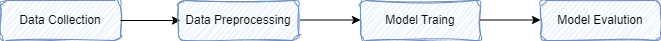

### Step 10 : Ways to Improve the Model
**Expand Dataset:**
- Increase the diversity of the dataset by incorporating more medical conditions and associated health tips from various demographics.
- Utilize publicly available medical datasets to enrich the model with a broader range of health tips.

**Enhance Feature Engineering:**
- Consider including additional features that could influence recommendations, such as lifestyle factors (e.g., exercise habits, dietary preferences) and psychosocial factors (e.g., stress levels, support systems).
- Use natural language processing (NLP) techniques to analyze and categorize health tips based on user sentiment and feedback.

**Incorporate User Feedback Loop:**
- Implement a feedback mechanism where users can rate the recommendations. Use this data to fine-tune the model and improve future recommendations.

### Conclusion
The model successfully generates health tips that are relevant to specific user profiles. By leveraging user attributes and similarity measures, it offers advice that aligns with common medical practices.<br>

####**Cosine Similarity**
Cosine Similarity measures the cosine of the angle between two non-zero vectors. It evaluates how similar two users are based on their profiles regardless of their magnitude (i.e., their actual values).<br>
This metric is particularly useful in high-dimensional spaces, where the absolute distance might be less meaningful.<br>

**Advantages:**

- **Focus on Direction:** Since it focuses on the orientation of the vectors rather than their magnitude, it can effectively identify users with similar preferences even if they have different levels of the features ***(e.g., age or varying severity of medical conditions).***

- **Normalization:** The cosine similarity normalizes the data, making it robust to variations in user profiles. This is especially beneficial when dealing with attributes like age and medical conditions, where users might have different scales.

- **Handling Sparse Data:** In many real-world datasets like *(user profiles)*, data can be sparse. Cosine similarity excels in such cases as it can still find meaningful similarities among users based on the angle, even when many features are zero.

**Application:**
- In a recommendation system for health tips to recommend tips to users who are similar in their health conditions and demographics, regardless of how severe their conditions are.
- Cosine similarity can effectively find these users, leading to relevant and personalized recommendations.<br>

**Cosine Similarity** is preferable when we want to focus on the similarity of user profiles in a high-dimensional space and need to handle variations in scale and sparsity. It is particularly useful when the directionality of user preferences matters more than their exact values.<br>


In conclusion, this recommendation system holds promise as a tool for enhancing health management and improving user outcomes. With ongoing refinements and a commitment to user-centric design, it can serve as a valuable resource for individuals seeking personalized health advice.